In [390]:
import lsst.meas.astrom as measAstrom
import lsst.daf.base as dafBase
import lsst.pipe.base as pipeBase
import lsst.daf.persistence as dafPersist

import lsst.afw.display.ds9 as ds9
import DiaSourceTools as DSTools

import lsst.afw.table as afwTable
import lsst.afw.geom as afwGeom

import numpy as np

In [391]:
DATADIR="/renoir_data_02/jpreyes/lsst_data/CFHTLS_master/"
butler = dafPersist.Butler(DATADIR+"/output")

In [422]:
visits = butler.queryMetadata("deepDiff_differenceExp", format=['visit', 'date'],dataId={'filter':'r'})

In [423]:
visits.remove((849685, '2006-05-24'))
visits.remove((849686, '2006-05-24'))
#removing these, we have a 6 points curve
#visits.remove((851057, '2006-06-06'))
#visits.remove((851058, '2006-06-06'))
#visits.remove((851059, '2006-06-06'))

In [424]:
subtr_visits = []
dates = []

for visit, date in visits:
    if butler.datasetExists("deepDiff_differenceExp", {'visit': visit , 'filter':'r' , 'ccd':14}) and date not in dates:
       
        if len(dates) == 0:
            days=0
        else:
            days = np.datetime64(date)-np.datetime64(dates[0])
            days = days.item().days
            
        dates.append(date)   
        
        diffExp = butler.get("deepDiff_differenceExp", {'visit': visit , 'filter':'r' , 'ccd':14})
        diaSrcs = butler.get("deepDiff_diaSrc", {'visit': visit , 'filter':'r' , 'ccd':14})
        
        class_diaSrcs = diaSrcs.copy()
        class_diaSrcs.clear()
        
        fluxes, sigmas = DSTools.get_fluxes_and_sigmas(diaSrcs, "base_PeakLikelihoodFlux_flux")

        m_sigma = np.mean(sigmas)
        t_sigma = 5*m_sigma

        sources = DSTools.get_sources_over_sigma(diaSrcs, t_sigma, "base_PeakLikelihoodFlux_flux")
        for source in sources:
            try:
                stamp = DSTools.get_stamp(source, diffExp)
                stamp_clone = stamp.clone()

                results = DSTools.detect_diasources(stamp_clone, doSmooth=True)
                negFps = len(results.fpSets.negative.getFootprints())
                posFps = len(results.fpSets.positive.getFootprints())
    
                #if negFps == 0:
                if True:
                    class_diaSrcs.addNew()
                    class_diaSrcs.append(source)
                    
                    
            except Exception, e:
                pass
                #print e
        print visit
        subtr_visits.append(((visit, days), class_diaSrcs))        

836493
837002
838853
839309
844210
844489
844845
845345
849373
849687
850177
850586
851057
852890
853232
853539
853727
858537
859608
860146


In [396]:
print len(subtr_visits)

20


In [425]:
paired_matches = []
for i, (visit, diaSrcs) in enumerate(subtr_visits):
    
    if i+1 == len(subtr_visits):
        break
    
    next_visit, next_diaSrcs = subtr_visits[i+1]
    
    match = afwTable.matchRaDec(diaSrcs, next_diaSrcs, afwGeom.Angle(1./3600., afwGeom.degrees)) 
    for m in match:
        paired_matches.append((visit, next_visit, m))

In [426]:
light_curves = []
c_paired_matches = list(paired_matches)

while len(c_paired_matches)>0:
    visit, n_visit, match = c_paired_matches.pop(0)
    points = []
    points.append((visit,match.first))
    points.append((n_visit,match.second))
    add_pair_to_list(light_curves, points) 
    
            
    

In [489]:
light_cs_copy = list(light_curves)


for i, lc in enumerate(light_cs_copy):
    j=i+1
    while j < len(light_cs_copy):
        compar_lc = light_cs_copy[j]
        
        
        if source_distance(lc[-1][-1], compar_lc[0][-1]) < 1:
            #print "match"
            lc.extend(compar_lc)
            light_cs_copy.pop(j)
        j+=1
    

In [492]:
print len(light_curves)
print len(t_light_curves)
print len(light_cs_copy)

86
39
59


In [ ]:
for i in range(len(light_curves)):
    for j in range(i, len(light_curves)):
        if i != j:
            lc1= light_curves[i]
            lc2= light_curves[j]
            
            p_source1 = lc1[-1]
            p_source2 = lc2[0]
            src = p_source1[-1]
            src2 = p_source2[-1]
            ra, dec = src['coord_ra'], src['coord_dec']
            ra2, dec2 = src2['coord_ra'], src2['coord_dec']
            
            r=np.sqrt((float(ra)-float(ra2))**2+(float(dec)-float(dec2))**2)/3.14159*180*3600
            
            if r<1:
                print "===Match==="
                print i,j
                print ra, dec
                print ra2, dec2
                print lc1[0]
                print lc2[0]
    

In [448]:
import math

src = p_source1[-1]
src2 = p_source2[-1]
ra, dec = src['coord_ra'], src['coord_dec']
ra2, dec2 = src2['coord_ra'], src2['coord_dec']

r=np.sqrt((float(ra)-float(ra2))**2+(float(dec)-float(dec2))**2)/3.14159*180*3600
print r

417.357233746


In [488]:
def source_distance(src1, src2):
    ra, dec = src1['coord_ra'], src1['coord_dec']
    ra2, dec2 = src2['coord_ra'], src2['coord_dec']
            
    return np.sqrt((float(ra)-float(ra2))**2+(float(dec)-float(dec2))**2)/3.14159*180*3600

def add_pair_to_list(light_curves, pair):
    
    #print pair
    for lc in light_curves:
        v, s = pair[0]
        if lc[-1][-1].getId() == pair[0][-1].getId():
            
            lc.append(pair[-1])
            return True
    light_curves.append(pair)
    return False

def threshold_light_curves(light_curves, threshold):
    t_light_curves = [lc for lc in light_curves if len(lc) >= threshold]
    return t_light_curves
    

In [491]:
t_light_curves = threshold_light_curves(light_curves, 3)
#for lc in t_light_curves:
#    print len(lc)

In [430]:
from astropy.table import Table
import sncosmo
def build_lightcurve(source_list):
    """
    Assemble a light curve data table from available files.
    """
        
    bandpasses = ['r']
  
        
    lightcurve = {}
    lightcurve['bandpass'] = []
    lightcurve['mjd'] = []
    lightcurve['ra'] = []
    lightcurve['dec'] = []
    lightcurve['flux'] = []
    lightcurve['flux_error'] = []
    lightcurve['zp'] = []
    lightcurve['zpsys'] = []

  
    for visit, src in source_list:

        #print 'yep',visit
        lightcurve['bandpass'].append(str('sdss' + bandpasses[0]))
        lightcurve['mjd'].append(visit[-1])
        lightcurve['ra'].append(src['coord_ra'])
        lightcurve['dec'].append(src['coord_dec'])
        lightcurve['flux'].append(src['base_PeakLikelihoodFlux_flux'])
        lightcurve['flux_error'].append(src['base_PeakLikelihoodFlux_fluxSigma'])
        #lightcurve['flux'].append(src['base_CircularApertureFlux_12_0_flux'])
        #lightcurve['flux_error'].append(src['base_CircularApertureFlux_12_0_fluxSigma'])
        lightcurve['zp'].append(25.0)
        lightcurve['zpsys'].append('ab')
    lightcurve = Table(data=lightcurve)
    return lightcurve  

def visualize_lightcurve(lightcurve, color='black'):
    """
    Make a simple light curve plot.
    """
    if lightcurve is None:
        raise ValueError('No lightcurve yet. Use build_lightcurve first.')

    fig = sncosmo.plot_lc(lightcurve, color=color)

    #return fig


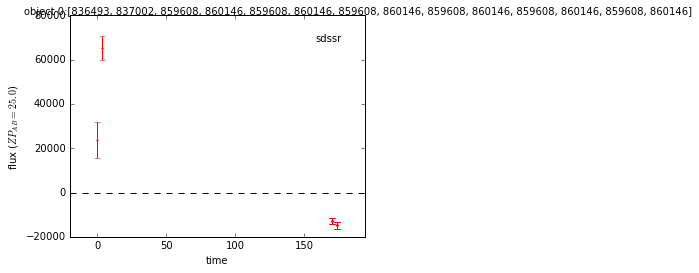

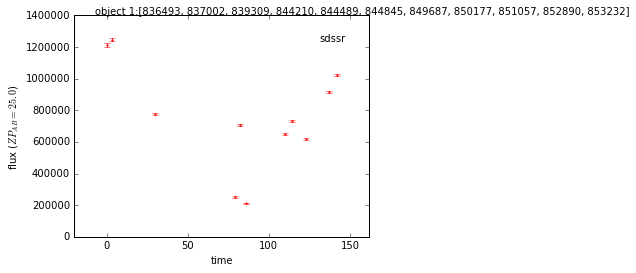

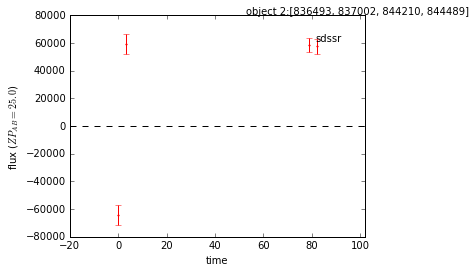

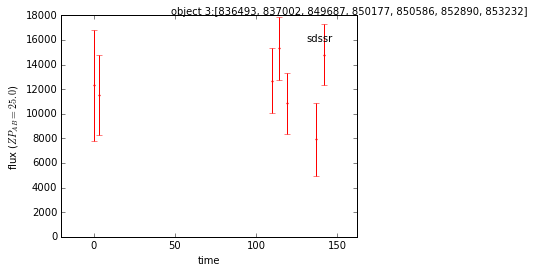

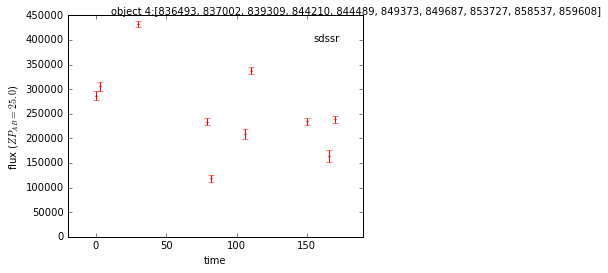

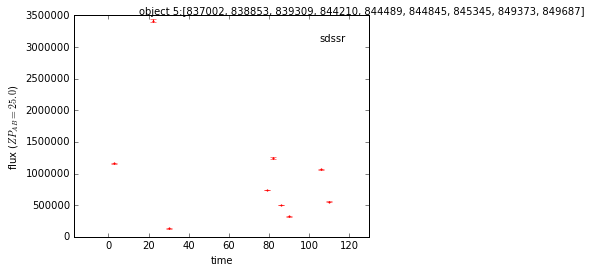

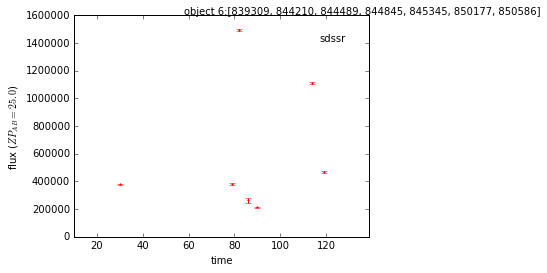

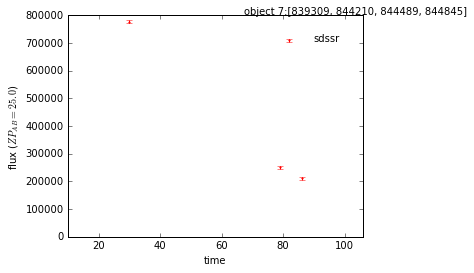

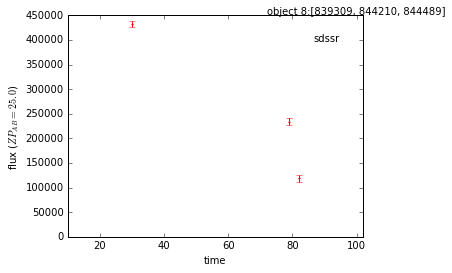

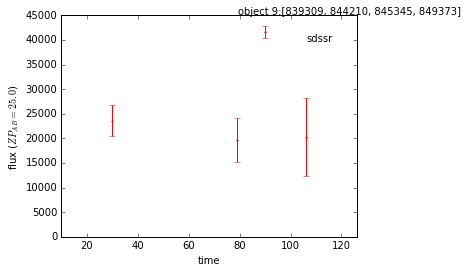

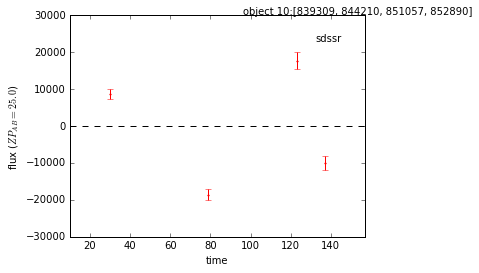

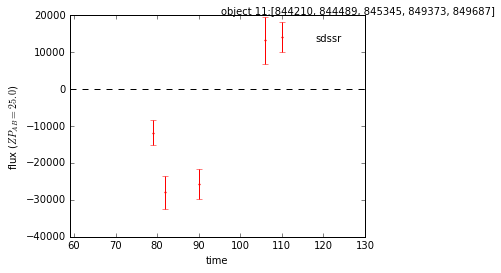

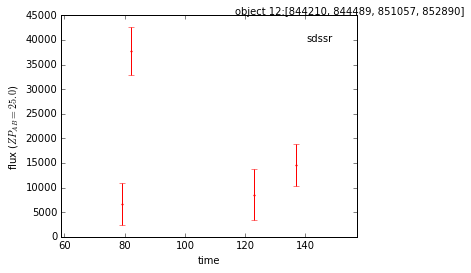

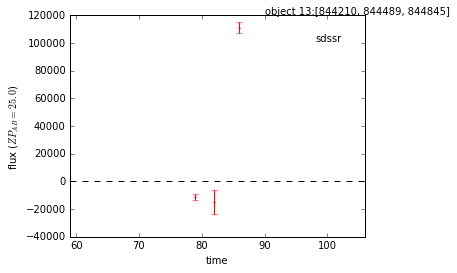

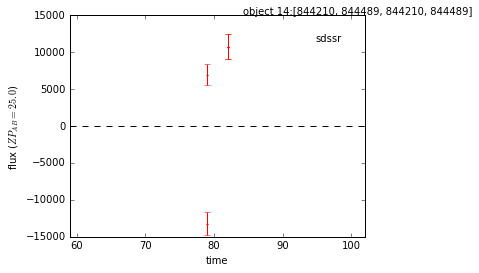

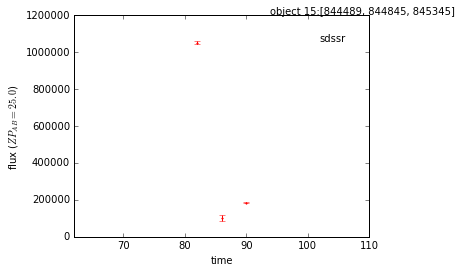

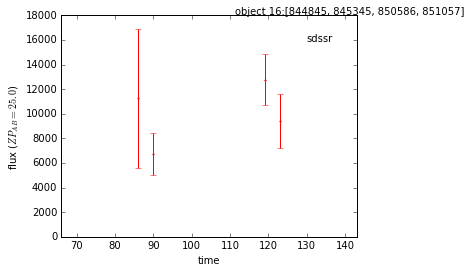

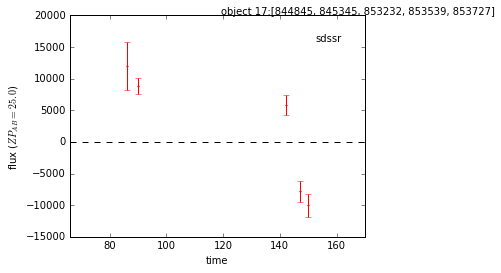

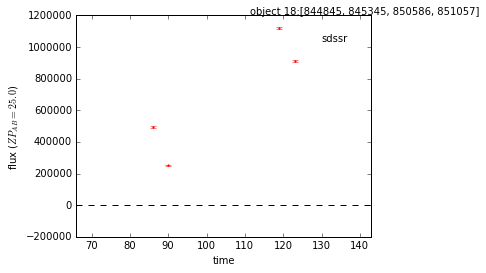

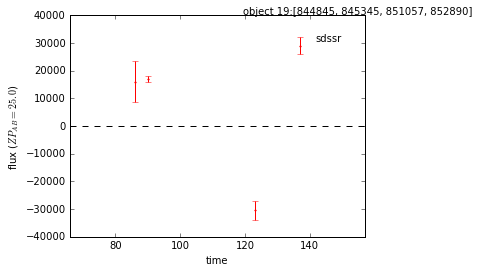

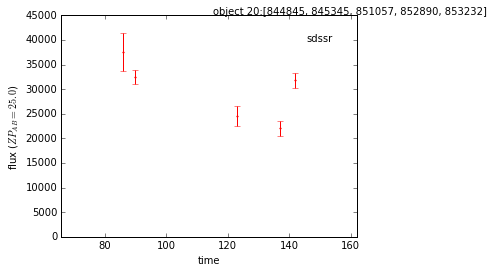

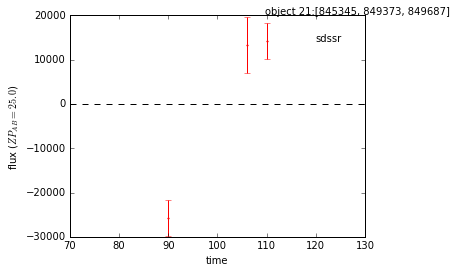

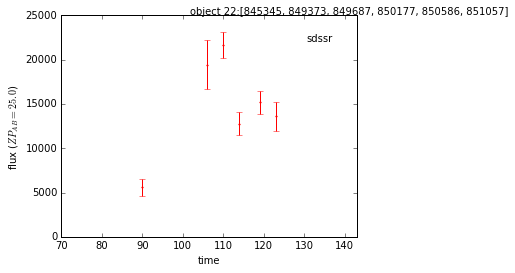

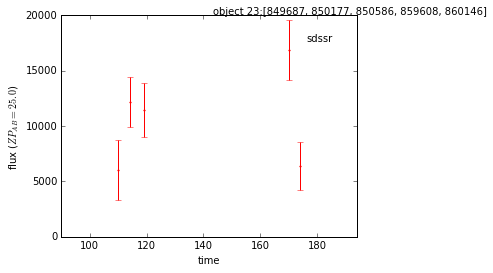

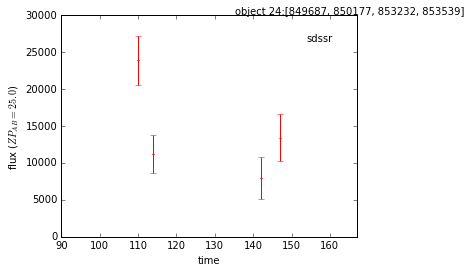

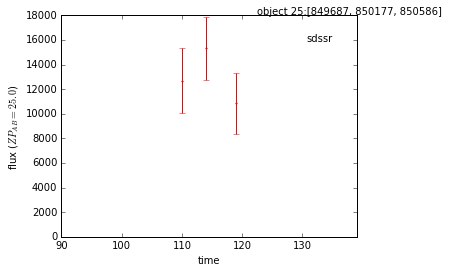

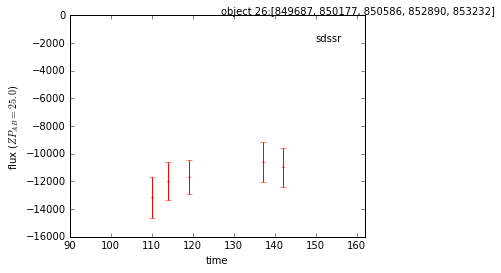

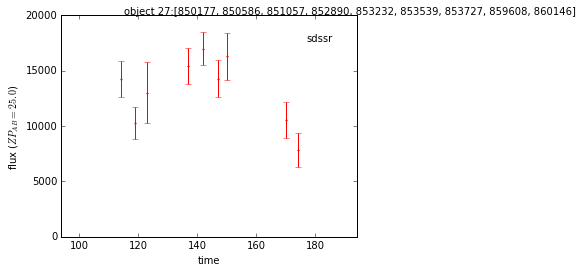

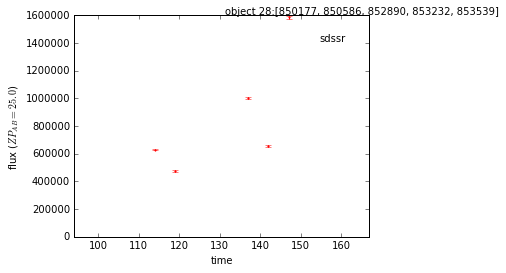

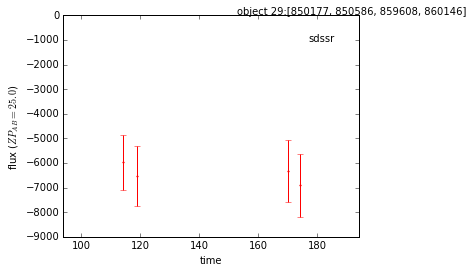

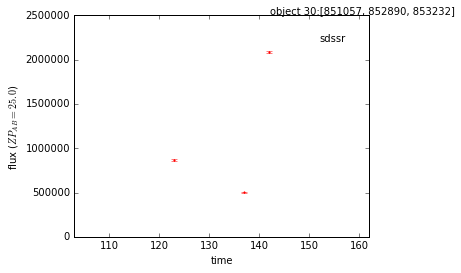

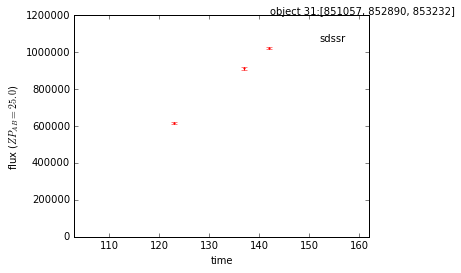

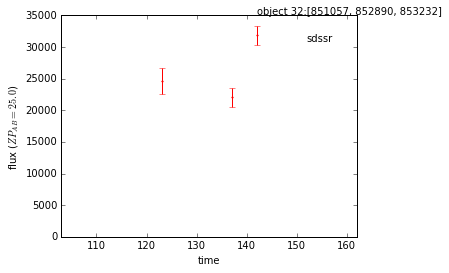

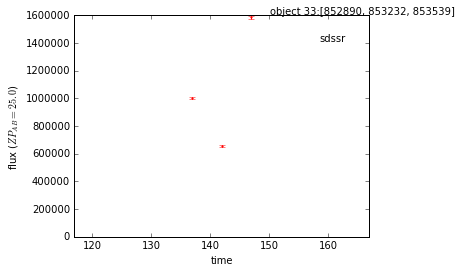

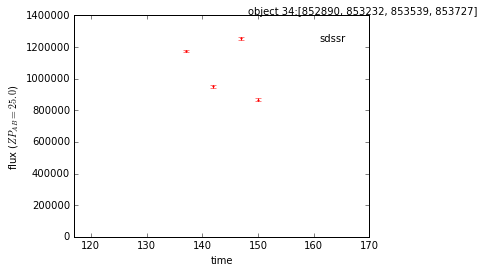

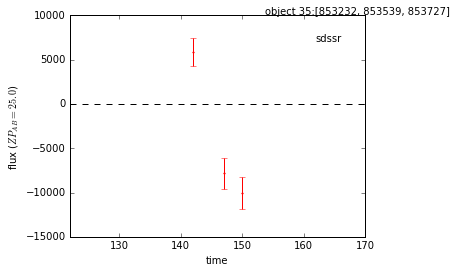

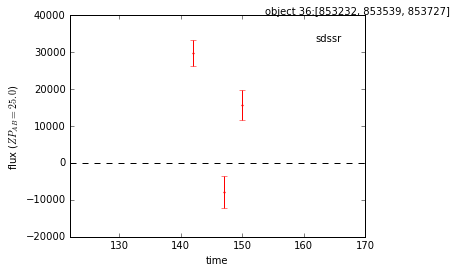

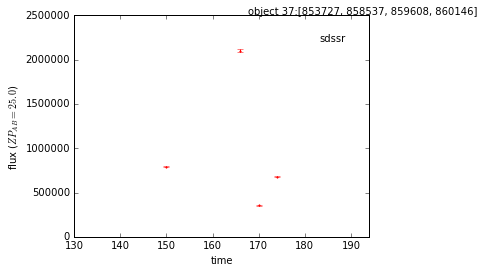

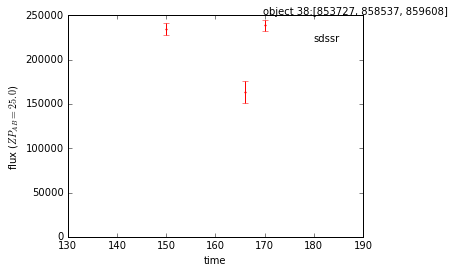

In [495]:
%matplotlib inline
for i, light_c in enumerate(t_light_curves):
    lc = build_lightcurve(light_c)
    #print lc
    #visualize_lightcurve(lc, color='red')
    visits = [visit[0] for visit, data in light_c ]
    #print visits
    fig = sncosmo.plot_lc(lc, color='red', xfigsize=10)
    axes = fig.get_axes()
    xlim = axes[0].get_xlim()
    axes[0].set_xlim(xlim[0]-10, xlim[1]+10)
    fig.suptitle("object "+str(i)+":"+str(visits))
    fig.show()


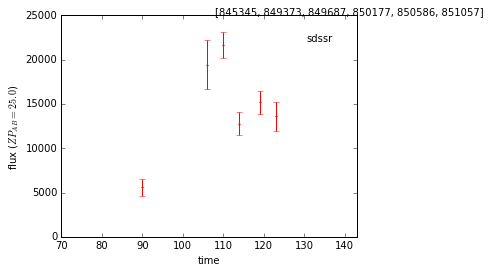

In [497]:
tl = t_light_curves[22]
lc = build_lightcurve(tl)
#print lc
#visualize_lightcurve(lc, color='red')
visits = [visit[0] for visit, data in tl ]
#print visits
fig = sncosmo.plot_lc(lc, color='red', xfigsize=10)
axes = fig.get_axes()
xlim = axes[0].get_xlim()
axes[0].set_xlim(xlim[0]-10, xlim[1]+10)
fig.suptitle(visits)
fig.show()

In [598]:
reload(DSTools)

<module 'DiaSourceTools' from 'DiaSourceTools.py'>

In [611]:
i = 1
for tl in t_light_curves:
    try:
        dataidlist = [{'visit': visit[0] , 'filter':'r' , 'ccd':14}  for visit, data in tl]
        source = tl[0][-1]
        DSTools.get_time_mosaic(butler, dataid_list, source, frame=i, equalize=True, title="object n. "+str(i))
        ds9.setMaskTransparency(100, frame=i)
        i+=1
    except Exception, e:
        
        i+=1
        print e
    


  File "src/image/Image.cc", line 92, in static lsst::afw::image::ImageBase<PixelT>::_view_t lsst::afw::image::ImageBase<PixelT>::_makeSubView(const Extent2I&, const Extent2I&, const _view_t&) [with PixelT = float; lsst::afw::image::ImageBase<PixelT>::_view_t = boost::gil::image_view<boost::gil::memory_based_2d_locator<boost::gil::memory_based_step_iterator<boost::gil::pixel<float, boost::gil::layout<boost::mpl::vector1<boost::gil::gray_color_t> > >*> > >; lsst::afw::geom::Extent2I = lsst::afw::geom::Extent<int, 2>]
    Box2I(Point2I(1742,-434),Extent2I(49,49)) doesn't fit in image 2048x4612 {0}
lsst::pex::exceptions::LengthError: 'Box2I(Point2I(1742,-434),Extent2I(49,49)) doesn't fit in image 2048x4612'


  File "src/image/Image.cc", line 92, in static lsst::afw::image::ImageBase<PixelT>::_view_t lsst::afw::image::ImageBase<PixelT>::_makeSubView(const Extent2I&, const Extent2I&, const _view_t&) [with PixelT = float; lsst::afw::image::ImageBase<PixelT>::_view_t = boost::gil::image_vie

In [594]:
ds9.mtv(diffExp)

ds9 doesn't appear to be running (XPA: XPA returned NULL, (;iconify no; raise)), I'll try to exec it for you


In [604]:
dataid = dataidlist[0]

diffExp = butler.get("deepDiff_differenceExp", dataid)
sciExp  = butler.get("calexp", dataid)
tmpExp = butler.get("deepDiff_warpedExp", dataid)
bgConf = sDet.BackgroundConfig()
background,tmpExp = sDet.estimateBackground(tmpExp,bgConf,True)


s1 = DSTools.get_stamp(source, sciExp)
s2 = DSTools.get_stamp(source, tmpExp)
s3 = DSTools.get_stamp(source, diffExp)

In [608]:
ds9.mtv(s1, frame=1)
ds9.mtv(DSTools.equalize_image(s1), frame=2)